In [6]:
# Parameters
vname = "temp"
model_name = "AWICM-3"
model_path = "/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"
reference_path = "/work/ab0246/a270092/postprocessing/climatologies/fdiag/"
reference_years = "1985"
model_start = 1990
model_end = 1991
remap_resolution = "180x91"
year=[model_start,model_end]
#remap_resolution = "180x91"
mesh_file = "mesh.nc"
meshpath = "/work/ab0246/a270092/input/fesom2/core2/"
out_path = "./output/"
dpi = 150
tripyview_path="/home/a/a270275/tripyview"
tripyview_path="/home/a/a270275/tripyview"
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
save_path         = '/work/ab0995/a270275/runconfig/Results/AWICM3_test031' #~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = 'AWICM3_test018' # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/work/ab0995/a270275/experiments/5Ymulti_diag/outdata/fesom/')


input_names   = list()
input_names.append('Fesom 2.6')
input_paths = ["/work/ab0995/a270275/experiments/awicm3test011/outdata/fesom"]
# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False


mon, day, record, box, depth = None, None, None, None, None

In [7]:
# Add the parent directory to sys.path and load config
import sys
import os
import pdb
print("tripypath",tripyview_path)
sys.path.append(tripyview_path)
from config import *

model_path = os.path.dirname(model_path)

# Mark as started
SCRIPT_NAME = "part9_rad_vs_ceres.ipynb"   #ADAPT
update_status(SCRIPT_NAME, " Started")


tripypath /home/a/a270275/tripyview


[########################################] | 100% Completed | 705.01 ms


/tmp/ipykernel_3506645/48903849.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])  # Prevents extra box while preserving layout


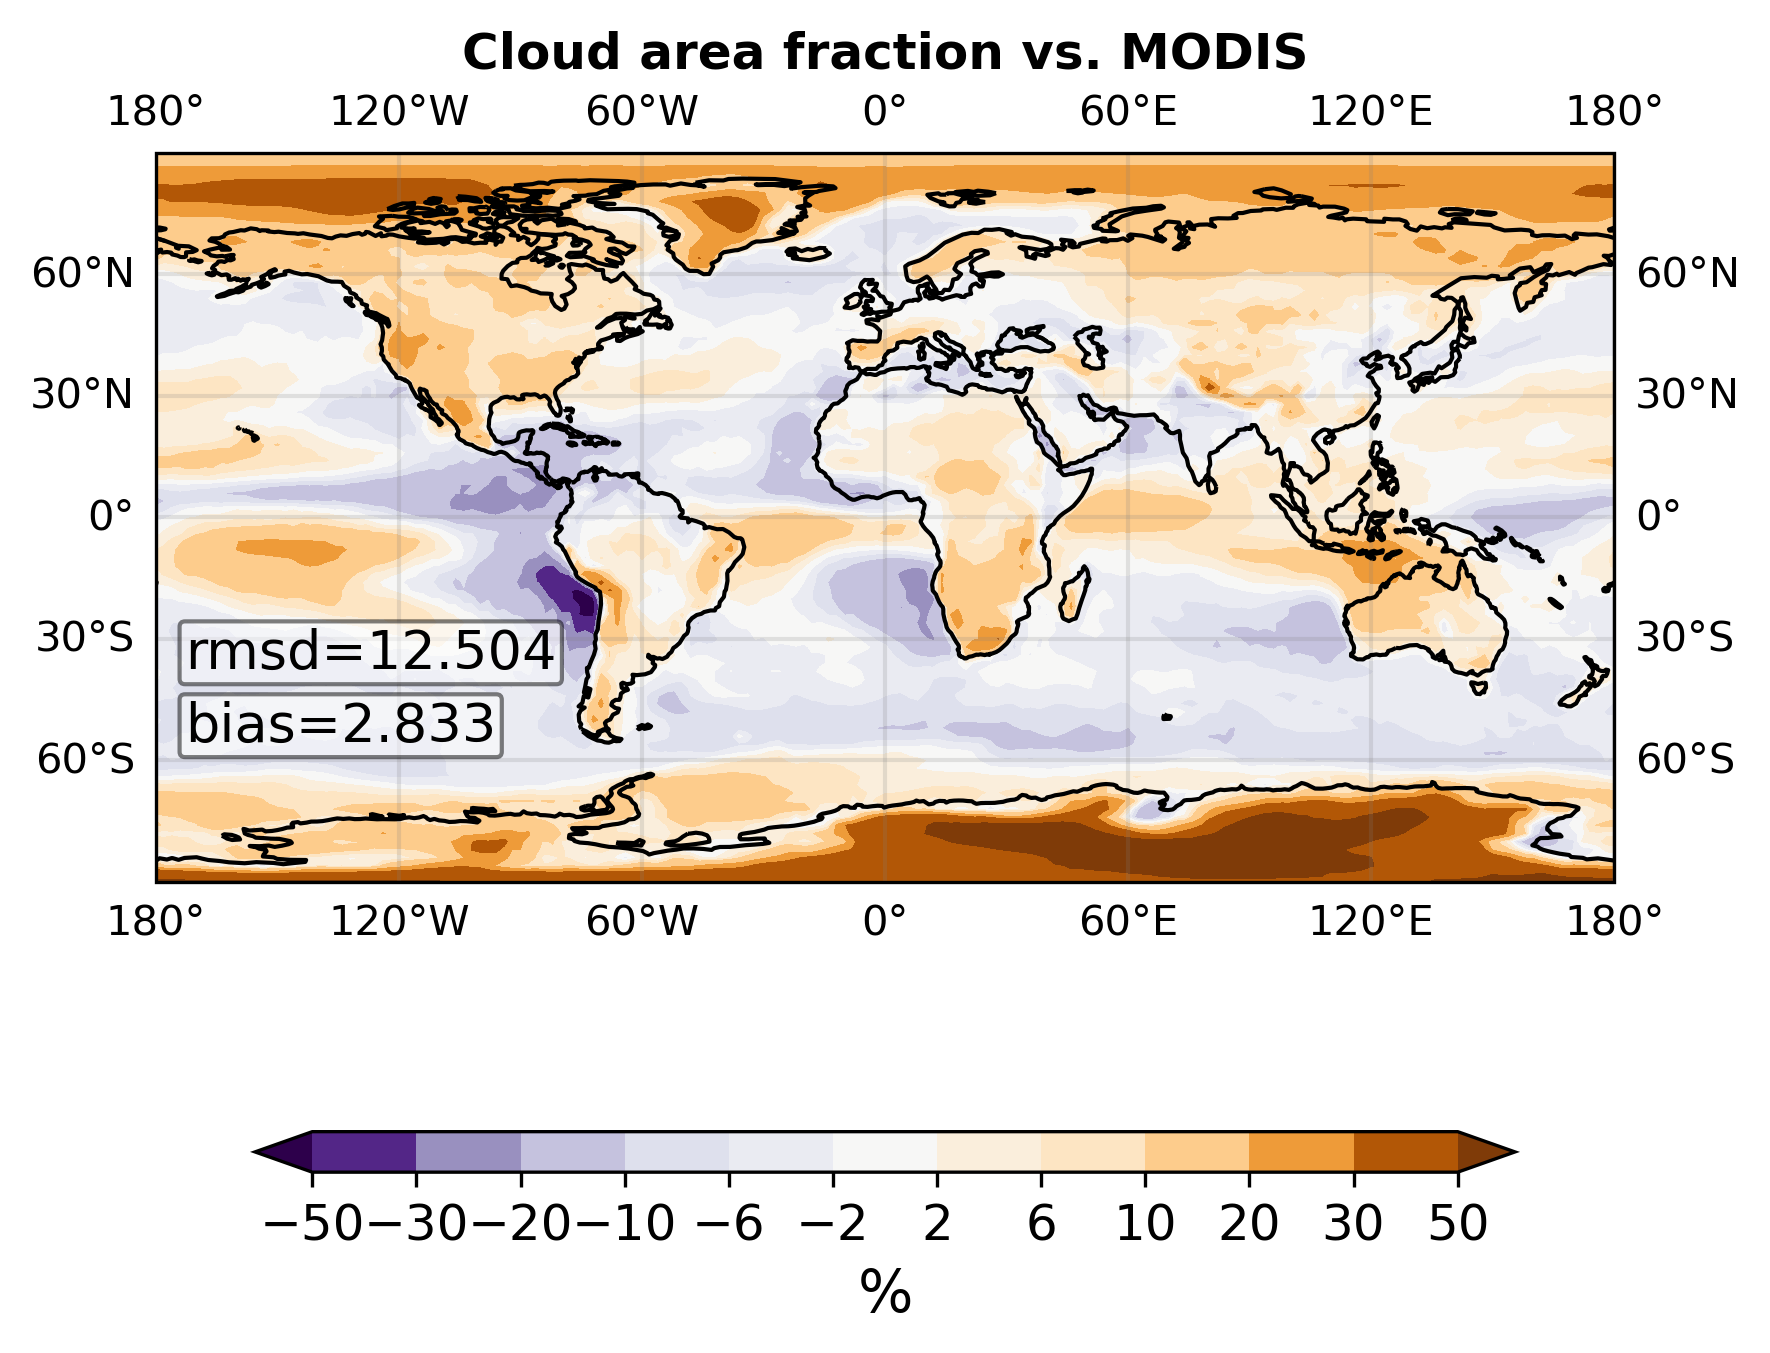

In [9]:

# Load MODIS climatology data

# parameters cell
input_paths = [model_path]
input_names = [model_name]
exps = list(range(model_start, model_end+1))
saved_filenames=[]
out_path = save_path +  "/figures"
climatology_files = ['clt_MODIS_yearmean.nc']
climatology_path =  observation_path+'/MODIS/'

figsize=(6, 4.5)
dpi = 300
ofile = None
res = [180, 91]
variable = ['tcc']
variable_clim = 'clt'
title='Cloud area fraction vs. MODIS'
mapticks = [-50,-30,-20,-10,-6,-2,2,6,10,20,30,50]

contour_outline_thickness = 0
levels = np.linspace(-5, 5, 21)

def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Mean Deviation weighted
def md(predictions, targets, wgts):
    output_errors = np.average((predictions - targets), axis=0, weights=wgts)
    return (output_errors).mean()

# Load CERES satobs data (https://doi.org/10.1175/JCLI-D-17-0208.1)


CERES_path = climatology_path + climatology_files[0]
CERES_Dataset = Dataset(CERES_path)
CERES_Data = OrderedDict()
CERES_CRF = CERES_Dataset.variables[variable_clim][:]

# Load model data in chunks of 5
def load_parallel(variable, path):
    data1 = cdo.timmean(input="-remapcon,r" + str(res[0]) + "x" + str(res[1]) + " " + str(path), returnArray=variable) * 100
    return data1

data = OrderedDict()
chunk_size = 5  # Process in chunks of 5

for exp_path, exp_name in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        datat = []
        for i in range(0, len(exps), chunk_size):
            chunk = exps[i:i + chunk_size]
            t = []
            for exp in chunk:
                path = f"{exp_path}/oifs/atm_remapped_1m_{v}_1m_{exp:04d}-{exp:04d}.nc"
                t.append(dask.delayed(load_parallel)(v, path))
            with ProgressBar():
                datat_chunk = dask.compute(*t, scheduler='threads')
            datat.extend(datat_chunk)
        data[exp_name][v] = np.squeeze(datat)

# Compute Model Mean
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()

for exp_name in input_names:
    crf_sw_model[exp_name] = np.squeeze(data[exp_name]['tcc']) 
    crf_sw_model_mean[exp_name] = np.mean(crf_sw_model[exp_name], axis=0)
    if len(np.shape(crf_sw_model_mean[exp_name])) > 2:
        crf_sw_model_mean[exp_name] = np.mean(crf_sw_model_mean[exp_name], axis=0)

crf_sw_satobs_mean = np.mean(CERES_CRF, axis=0)

# Longitude & Latitude Handling
lon = np.arange(0, 360, 2)
lat = np.linspace(-90, 90, 91)  # Ensures correct shape for latitude

crf_sw_model_mean[exp_name], lon_cyclic = add_cyclic_point(crf_sw_model_mean[exp_name], coord=lon)
crf_sw_satobs_mean, _ = add_cyclic_point(crf_sw_satobs_mean, coord=lon)

# Compute Weighted RMSD & MD
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[:, np.newaxis]  # Expand to (lat, 1) and match dimensions
wgts = np.broadcast_to(wgts, crf_sw_model_mean[exp_name].shape)  # Broadcast to (lat, lon)

rmsdval = sqrt(mean_squared_error(crf_sw_model_mean[exp_name], crf_sw_satobs_mean, sample_weight=wgts))
mdval = md(crf_sw_model_mean[exp_name], crf_sw_satobs_mean, wgts)

# Define figure layout
nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=dpi)

if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

# Loop through input names and plot
for i, exp_name in enumerate(input_names):
    ax = axes[i]
    ax.add_feature(cfeature.COASTLINE, zorder=3)

    # Contour plot
    imf = ax.contourf(lon_cyclic, lat, crf_sw_model_mean[exp_name] - crf_sw_satobs_mean,
                      cmap='PuOr_r', levels=mapticks, extend='both',
                      transform=ccrs.PlateCarree(), zorder=1)

    line_colors = ['black' for _ in imf.levels]
    imc = ax.contour(lon_cyclic, lat, crf_sw_model_mean[exp_name] - crf_sw_satobs_mean,
                     colors=line_colors, levels=mapticks,
                     linewidths=contour_outline_thickness,
                     transform=ccrs.PlateCarree(), zorder=1)

    ax.set_ylabel('W/m²')
    ax.set_xlabel('Simulation Year')
    ax.set_title(title, fontweight="bold")

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='-')
    gl.xlabels_bottom = False

    # Bias & RMSD Text
    textrsmd = f'rmsd={round(rmsdval, 3)}'
    textbias = f'bias={round(mdval, 3)}'
    props = dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5)

    ax.text(0.02, 0.35, textrsmd, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props, zorder=4)
    ax.text(0.02, 0.25, textbias, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props, zorder=4)

# Add Colorbar (Positioned Correctly)
cbar_ax_abs = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # Adjusted position to remove box effect
cbar_ax_abs.tick_params(labelsize=12)
cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal', ticks=mapticks)
cb.set_label(label="%", size=14)
cb.ax.tick_params(labelsize=12)

# Remove extra subplot spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Fine-tuned spacing
plt.tight_layout(rect=[0, 0.07, 1, 1])  # Prevents extra box while preserving layout

# Save figure
ofile = variable[0] + '_vs_MODIS'
ofile='_part10_clt_vs_modis'+'_area_fraction'
if ofile is not None:
    plt.savefig(out_path+"/"+tripyrun_name +ofile, dpi=dpi, bbox_inches='tight')
    saved_filenames.append(out_path + ofile+ '.png')

# Mark script as completed
update_status(SCRIPT_NAME, "Completed")
